In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import glob
import pickle
import jax
import jax.numpy as jnp
import bayes3d as b
import genjax
import matplotlib.pyplot as plt

In [5]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [6]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

camera_image_1 = data["init"][0]
categories_on_table = data["init"][1]
target_category = data["init"][2]
table_info = data["init"][3] # table pose and dimensions
n_objects = 5

X_WT = b.t3d.pybullet_pose_to_transform(table_info[0])
X_WC = b.t3d.pybullet_pose_to_transform(camera_image_1["camera_pose"])
X_CT = b.t3d.inverse_pose(X_WC) @ X_WT

def image_to_rgbd(camera_image_1):
    K = camera_image_1['camera_matrix']
    rgb = camera_image_1['rgbPixels']
    depth = camera_image_1['depthPixels']
    camera_pose = camera_image_1['camera_pose']
    camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
    fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
    h,w = depth.shape
    rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
    return rgbd_original

rgbd_original = image_to_rgbd(camera_image_1)
print("Got rgbd_original")

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
print("Got rgb immage scaled down.")

b.setup_renderer(rgbd_scaled_down.intrinsics)

# os.path.join(os.path.abspath(''), 'bayes3d/assets/bop/ycbv/models')# 
model_dir = os.path.join(os.path.abspath('../..'), 'bayes3d/assets/bop/ycbv/models')
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
ycb_filenames = glob.glob(os.path.join(model_dir, "*.ply"))
ycb_index_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in ycb_filenames]
sorted_ycb_filenames = [s for _,s in sorted(zip(ycb_index_order, ycb_filenames))]

relevant_objects = [any(x in name for x in categories_on_table) for (i, name) in enumerate(b.utils.ycb_loader.MODEL_NAMES)]
relevant_object_names = [b.utils.ycb_loader.MODEL_NAMES[i] for i in range(len(b.utils.ycb_loader.MODEL_NAMES)) if relevant_objects[i]]
filtered_filenames = [sorted_ycb_filenames[i] for i in range(len(sorted_ycb_filenames)) if relevant_objects[i]]

table_dims = table_info[1:]
table_mesh = b.utils.make_cuboid_mesh(table_dims)
b.RENDERER.add_mesh(table_mesh, "table")
print("Added table mesh.")

pillar_mesh = b.utils.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.5]))
b.RENDERER.add_mesh(pillar_mesh, "pillar")
print("Added pillar mesh.")

for model_path in filtered_filenames:
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)
    print(f"Added mesh at path {model_path}.")

Got rgbd_original
Got rgb immage scaled down.


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
Added table mesh.
Added pillar mesh.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000002.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000003.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000011.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000013.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000021.ply.


In [57]:
from src.old_models.model import model, viz_trace_meshcat
args = (
    jnp.arange(5),
    jnp.arange(5),
    jnp.array([-jnp.ones(3)*2.0, jnp.ones(3)*2.0]),
    jnp.array([jnp.array([-1.0, -1.0, -jnp.pi]), jnp.array([1.0, 1.0, jnp.pi])]),
    b.RENDERER.model_box_dims
)
getimg = jax.jit(lambda key : model.simulate(key, args).get_retval().rendered[..., 2])

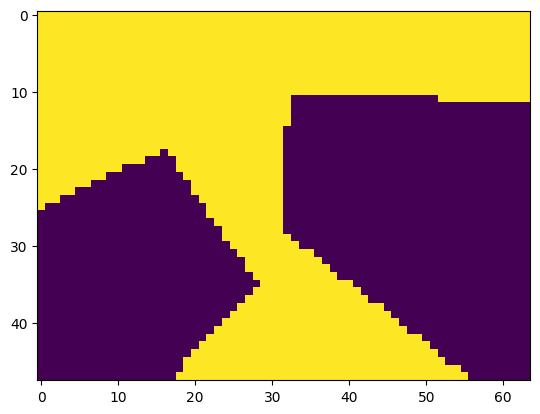

In [80]:
key, _ = jax.random.split(key)
plt.imshow(getimg(key))

In [11]:
trace.get_retval().rendered.shape

(48, 64, 3)

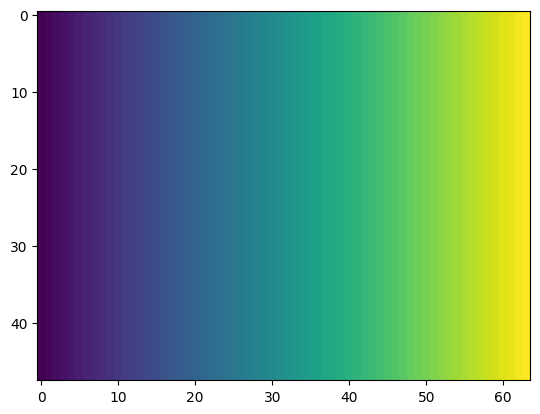

In [22]:
import matplotlib.pyplot as plt
plt.imshow(
    b.project_cloud_to_pixels(trace.get_retval().rendered.reshape(-1, 3), b.RENDERER.intrinsics).reshape(48, 64, -1)[..., 0]
)

In [32]:
trace.get_retval().rendered[..., 2].shape

(48, 64)

In [33]:
b.get_depth_image(trace.get_retval().rendered[..., 2], b.RENDERER.intrinsics)

ValueError: operands could not be broadcast together with shapes (48,64) (8,) 

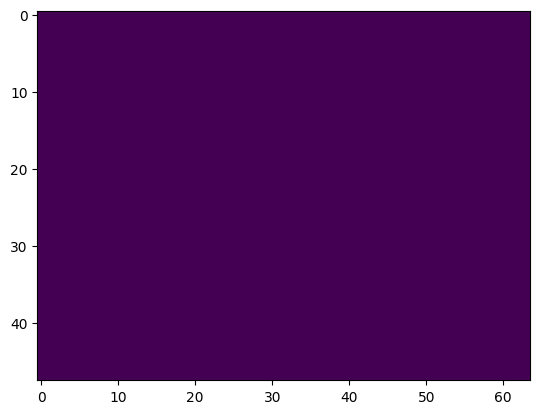

In [34]:
plt.imshow(trace.get_retval().rendered[..., 2])

In [3]:
import jax.numpy as jnp
inds = jnp.arange(-2, 5)
vals = jnp.arange(7)
jnp.where(inds < 0, 0, vals)

Array([0, 0, 2, 3, 4, 5, 6], dtype=int32)